In [33]:
import pandas as pd
import numpy as np
import os
import os.path, time
import zipfile as zp
import re
import random
from datetime import datetime, date
from datetime import datetime, timedelta
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from scipy import stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.base.model import LikelihoodModel

from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
import unicodedata
import seaborn as sns; sns.set()

### Subject List 

In [34]:
def sub_Dict():
    sub_Dict = dict({99: ['797','806','809','826','843','845','855','856','857'], 
                 114: ['1031','1153','1154','1157','1174','1262','1264','1266',
        '1364','1367','1379','1380','1381','1384','1435','1465','1467','1468','1489','1492','1493','1494','1495','1498','1519',
        '1520','1527','1532','1536','1541','1721','1722','1737','1741','1788','1791','1810','1812','1833','1934'],
        177:['2310','2316','2318','2323','2338','2339','2340','2348','2353','2356','2357','2358','2377',
            '2378','2381','2383','2385','2386','2387','2388','2389','2390','2391','2394','2395','2396','2399',
            '2401','2402','2404','2405','2407','2434','2444','2456',
             '2433','2447','2477','2479','2489','2547','2548','2549','2553','2555','2558','2559','2578']}) 
    return sub_Dict

def GetCohort(subID):
    subDict = sub_Dict()
    for key, value in subDict.items():
        if subID in value:
            return key
        
def subID_list():
    subID = ['797','806','809','826','843','845','855','856','857','1031','1153','1154','1157','1174','1262','1264','1266',
        '1364','1367','1379','1380','1381','1384','1435','1465','1467','1468','1489','1492','1493','1494','1495','1498','1519',
        '1520','1527','1532','1536','1541','1721','1722','1737','1741','1788','1791','1810','1812','1833','1934',
            '2310','2316','2318','2323','2338','2339','2340','2348','2353','2356','2357','2358','2377','2378',
             '2381','2383','2385','2386','2387','2388','2389','2390','2391','2394','2395','2396','2399',
             '2401','2402','2404','2405','2407','2434','2444','2456',
            '2433','2447','2477','2479','2489','2547','2548','2549','2553','2555','2558','2559','2578']
    return subID



## ESVT Model

In [35]:
def raw_data_df(sub,cohort):
    subID = subID_list()
    if cohort != 177:
        week_label = ['01','08','11','17','19','23','26','32','34','36','42','44','48','52','56']
    else:
        week_label = ['01','04','08','11','17','19','23','26','32','34','37','42','44','48','52','56']
    filelist = []
    file = []
    
    for i in range(len(week_label)):
        lottery_file = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort,week_label[i])
        filelist += zp.ZipFile(lottery_file).namelist()
        file.append(zp.ZipFile(lottery_file))
        
    sub_file = {}
    for i in range(len(subID)):
        key = subID[i]
        sub_file.setdefault(key, [])
        sub_file[key].extend([s for s in filelist if subID[i] in s])


    appended_data = []
    for i in range(len(file)):
        
        data = pd.read_csv(file[i].open(sub_file[sub][i]))
        
        appended_data.append(data)
    df = pd.concat(appended_data)
    
    r = df[df['data_rounds_trial_type'] == 'risk']
    return r

def analysis_data_all(df,obs):
    df.data_rounds_selected_sure_bet_reward = df.data_rounds_selected_sure_bet_reward.astype(int)
    df_temp = df[['participant_id','data_rounds_reward_probability','data_rounds_reward_value','data_rounds_selected_sure_bet_reward']]
    df_temp.loc[:,'data_rounds_selected_sure_bet_reward'] = df_temp['data_rounds_selected_sure_bet_reward'].replace({0:1, 1:0})
    df_temp = df_temp.rename(columns={"data_rounds_selected_sure_bet_reward": "data_rounds_selected_variable_bet_reward"})
    x = np.array(df_temp['data_rounds_reward_value'])
    x = np.reshape(x,[obs,1])
    s = 5*np.ones((obs,1))
    p = np.array(df_temp['data_rounds_reward_probability'])
    p = np.reshape(p,[obs,1])
    

    SubjectChoices = np.array(df_temp['data_rounds_selected_variable_bet_reward'])
    SubjectChoices = np.reshape(SubjectChoices,[obs,1])
    exog = np.concatenate((x,s,p), axis=1)
    endog = SubjectChoices

    return df_temp, exog, endog  

def sv(x,p,s,gamma,alpha,M):
    
    SV_X = p*(np.power(x,alpha)/(np.power(x,alpha)+np.power(M,alpha)))
    SV_Y = np.power(s,alpha)/(np.power(s,alpha)+np.power(M,alpha))
    
    #logisitc regression 
    #difference between subjective value
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y)))
    return prob

def _ll_nb2_ESVT(enog, exog, alpha, M, gamma):

    x = exog[:,0]
    s = exog[:,1]
    p = exog[:,2]
    SV_X = p*(np.power(x,alpha)/(np.power(x,alpha)+np.power(M,alpha)))
    SV_Y = np.power(s,alpha)/(np.power(s,alpha)+np.power(M,alpha))
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y)))
    temp = 1-prob
    prob[enog == 0] = temp[enog == 0]
    negLL = -np.sum(np.log(prob))
    return negLL

class ESVT(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(ESVT, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self,parms):
        alpha = parms[0]
        M = parms[1]
        gamma = parms[2]
        negll = _ll_nb2_ESVT(self.endog, self.exog, alpha, M, gamma)          
        return negll

    def fit(self, start_params, method='L-BFGS-B',bounds = ((1, None), (0, None), (0, None)) ,maxiter=10000, maxfun=50000, **kwds):
        #if start_params == None:
            # Reasonable starting values
            #start_params = np.array([3.5,14,25])
            
        return super(ESVT, self).fit(start_params=start_params,method='lbfgs',bounds = ((1, None), (0, None), (0, None)),
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

## ESVT fitting

In [36]:
sub = sub_Dict().get(177)
len(sub)

48

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


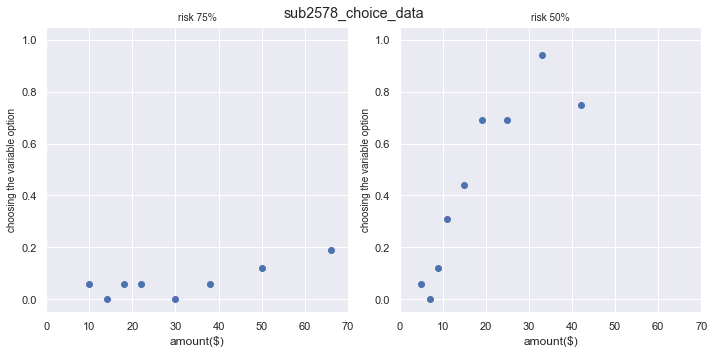

In [37]:
trialNo = 272
xx = np.arange(0,trialNo,1)
xx = xx.reshape(trialNo,1)

p_risk_high = 0.25*np.ones((trialNo,1))
p_risk_low = 0.5*np.ones((trialNo,1))
s = 5*np.ones((trialNo,1))



df = raw_data_df(sub[47],177)

df_temp, exog, endog = analysis_data_all(df,272)


risk_high = df_temp.query('data_rounds_reward_probability == 0.25').sort_values(by=['data_rounds_reward_value'])
risk_low = df_temp.query('data_rounds_reward_probability == 0.5').sort_values(by=['data_rounds_reward_value'])

#sv_risk_high = sv(xx,p_risk_high,s,res.params[2],res.params[0],res.params[1])
#sv_risk_low = sv(xx,p_risk_low,s,res.params[2],res.params[0],res.params[1])

risk_high_d = risk_high[['data_rounds_reward_value', 'data_rounds_selected_variable_bet_reward']]
risk_high_ratio = round(risk_high_d.groupby(risk_high_d.data_rounds_reward_value).sum()/16,2)

risk_low_d = risk_low[['data_rounds_reward_value', 'data_rounds_selected_variable_bet_reward']]
risk_low_ratio = round(risk_low_d.groupby(risk_low_d.data_rounds_reward_value).sum()/16,2)

reward_value_risk_low = risk_low_ratio.index.to_list()
reward_value_risk_high = risk_high_ratio.index.to_list()


## Plot 
fig, ax = plt.subplots(figsize=(10, 5))
#plt.suptitle('sub%s_choice_data\n gamma = %2.2f alpha = %2.2f M = %2.2f'%(sub,res.params[2],res.params[0],res.params[1]), y = 1,fontname="Helvetica", fontsize=12)
plt.suptitle('sub%s_choice_data'%sub[47])
ax1 = plt.subplot(121)


#plt.plot(xx, sv_risk_high,'pink')
plt.scatter(reward_value_risk_high, risk_high_ratio['data_rounds_selected_variable_bet_reward'])
ax1.set_xlabel('amount($)')
ax1.set_ylabel("choosing the variable option", fontname="Helvetica", fontsize=10)
ax1.set_title("risk 75%", fontname= "Helvetica", fontsize=10,loc='center')

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)

#plt.plot(xx, sv_risk_low,'pink')
plt.scatter(reward_value_risk_low, risk_low_ratio['data_rounds_selected_variable_bet_reward'])
ax2.set_xlabel('amount($)')
ax2.set_ylabel("choosing the variable option", fontname="Helvetica", fontsize=10)
ax2.set_title("risk 50%", fontname= "Helvetica", fontsize=10,loc='center')
plt.subplots_adjust(bottom=-1, right=0.8, top=0.8)
plt.xlim(0, 70)
plt.ylim(-0.05,1.05)
plt.tight_layout()
plt.savefig('../../Figures/lottery_choice_data/All/ESVT_fitting/sub%s_risk_choice_ESVT.png'%sub[47],dpi=1000)
plt.show()

## Expected Utility Model 

In [38]:
def raw_data(week,sub,cohort):
    subID = subID_list()
    if cohort !=177:
        week_label = [['01','01'],['08','11'],['17','19'],['23','26'],['32','34'],['36','42'],['44','48'],['52','56']]
    else:
        week_label = [['01','04'],['08','11'],['17','19'],['23','26'],['32','34'],['37','42'],['44','48'],['52','56']]
    lottery_file_1 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][0])
    filelist_1 = zp.ZipFile(lottery_file_1).namelist()
    lottery_file_2 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][1])
    filelist_2 = zp.ZipFile(lottery_file_2).namelist()
    
    sub_file = {}
    for i in range(len(subID)):
        key = subID[i]
        sub_file.setdefault(key, [])
        sub_file[key].extend([s for s in filelist_1 if subID[i] in s])
        sub_file[key].extend([s for s in filelist_2 if subID[i] in s])

    df1 = pd.read_csv(zp.ZipFile(lottery_file_1).open(sub_file[sub][0]))
    df2 = pd.read_csv(zp.ZipFile(lottery_file_2).open(sub_file[sub][1]))
    df = pd.concat([df1, df2])
    r = df[df['data_rounds_trial_type'] == 'risk']
    
    return r

def analysis_data_weekly(df):
    df.data_rounds_selected_sure_bet_reward = df.data_rounds_selected_sure_bet_reward.astype(int)
    df_temp = df[['participant_id','data_rounds_reward_probability','data_rounds_reward_value','data_rounds_selected_sure_bet_reward','data_rounds_trial_type','data_rounds_ambiguity']]
    df_temp.loc[df.data_rounds_trial_type  == 'ambiguity', 'data_rounds_reward_probability'] = 0.5
    df_temp.loc[:,'data_rounds_selected_sure_bet_reward'] = df_temp['data_rounds_selected_sure_bet_reward'].replace({0:1, 1:0})
    df_temp = df_temp.rename(columns={"data_rounds_selected_sure_bet_reward": "data_rounds_selected_variable_bet_reward"})
    x = np.array(df_temp['data_rounds_reward_value'])
    x = np.reshape(x,[70,1])
    p = np.array(df_temp['data_rounds_reward_probability'])
    p = np.reshape(p,[70,1])
    s = 5*np.ones((70,1))
    A = np.array(df['data_rounds_ambiguity'])
    A = np.reshape(A,[70,1])
    SubjectChoices = np.array(df_temp['data_rounds_selected_variable_bet_reward'])
    SubjectChoices = np.reshape(SubjectChoices,[70,1])
    exog = np.concatenate((x,p,s,A), axis=1)
    endog = SubjectChoices

    return exog, endog   

def _ll_nb2_EU(enog, exog, alpha, beta, gamma):

    x = exog[:,0]
    p = exog[:,1]
    s = exog[:,2]
    A = exog[:,3]
    SV_X = (p-beta*(A/2)) * np.power(x,alpha)
    SV_Y = np.power(s,alpha)
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y)))
    temp = 1-prob
    prob[enog == 0] = temp[enog == 0]
    negLL = -np.sum(np.log(prob))
    #negLL = -np.log(prob)
    return negLL

class EU(GenericLikelihoodModel):
#class Bin(LikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(EU, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self,parms):
        alpha = parms[0]
        beta = parms[1]
        gamma = parms[2]
        negll = _ll_nb2_EU(self.endog, self.exog, alpha, beta, gamma)          
        return negll
    

    def fit(self, start_params, method='L-BFGS-B',bounds = ((0, None), (-1, 1), (0, None)) ,maxiter=10000, maxfun=50000, **kwds):
        # we have one additional parameter and we need to add it for summary
        #self.exog_names.append('gamma')
        #if start_params == None:
            # Reasonable starting values
            #start_params = np.array([0.9,0,1])
            # intercept
            #start_params[-2] = np.log(self.endog.mean())
        return super(EU, self).fit(start_params=start_params,method='lbfgs',bounds = ((0, None), (-1, 1), (0, None)),
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)



## Choice ratio & RT

In [39]:
def rp_ratio(week,sub,cohort):
    df = raw_data(week,sub,cohort)

    
    amb = df.query('data_rounds_trial_type == "ambiguity"')
    amb_d = amb[['data_rounds_reward_value', 'data_rounds_selected_sure_bet_reward']]
    amb_ratio = 1 - (round(amb_d.data_rounds_selected_sure_bet_reward.sum()/36,2))
  
    risk = df.query('data_rounds_trial_type == "risk"')
    risk_d = risk[['data_rounds_reward_value', 'data_rounds_selected_sure_bet_reward']]
    risk_ratio = 1 - (round(risk_d.data_rounds_selected_sure_bet_reward.sum()/34,2))
    
    return amb_ratio, risk_ratio

def RT(week,sub,cohort):
    subID = subID_list()
    
    if cohort != 177:
        week_label = [['01','01'],['08','11'],['17','19'],['23','26'],['32','34'],['36','42'],['44','48'],['52','56']]
    else:
        week_label = [['01','04'],['08','11'],['17','19'],['23','26'],['32','34'],['37','42'],['44','48'],['52','56']]
    
    lottery_file_1 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][0])
    filelist_1 = zp.ZipFile(lottery_file_1).namelist()
    lottery_file_2 = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort, week_label[week-1][1])
    filelist_2 = zp.ZipFile(lottery_file_2).namelist()

    sub_file = {}
    for i in range(len(subID)):
        key = subID[i]
        sub_file.setdefault(key, [])
        sub_file[key].extend([s for s in filelist_1 if subID[i] in s])
        sub_file[key].extend([s for s in filelist_2 if subID[i] in s])

    df1 = pd.read_csv(zp.ZipFile(lottery_file_1).open(sub_file[sub][0]))
    RT_start = df1['start_time'].to_list()
    RT_end = df1['end_time'].to_list()
    s = list(set(RT_start))
    e = list(set(RT_end))
    dt_start = datetime.strptime(s[0][0:19], "%Y-%m-%d %H:%M:%S").time()
    dt_end = datetime.strptime(e[0][0:19], "%Y-%m-%d %H:%M:%S").time()

    RT1 = datetime.combine(date.today(), dt_end) - datetime.combine(date.today(), dt_start)

    df2 = pd.read_csv(zp.ZipFile(lottery_file_2).open(sub_file[sub][1]))
    RT_start = df2['start_time'].to_list()
    RT_end = df2['end_time'].to_list()
    s = list(set(RT_start))
    e = list(set(RT_end))
    dt_start = datetime.strptime(s[0][0:19], "%Y-%m-%d %H:%M:%S").time()
    dt_end = datetime.strptime(e[0][0:19], "%Y-%m-%d %H:%M:%S").time()

    RT2 = datetime.combine(date.today(), dt_end) - datetime.combine(date.today(), dt_start)
    mean_RT = (RT1+RT2)/2
    return RT1, RT2

In [43]:
subNo = len(subID_list())
subID = subID_list()

all_amb_ratio = np.empty([subNo, 8])
all_risk_ratio = np.empty([subNo, 8])
all_RT = np.empty([subNo, 8])
week = [1,2,3,4,5,6,7,8]
for i in range(len(subID)):
    for t in range(len(week)):
        cohort = GetCohort(subID[i])
        amb_ratio, risk_ratio = rp_ratio(week[t],subID[i],cohort)
        all_amb_ratio[i][t] =  amb_ratio
        all_risk_ratio[i][t] = risk_ratio
        RT1, RT2 = RT(week[t],subID[i],cohort)
        meanRT = (RT1.total_seconds()+RT2.total_seconds())/2
        all_RT[i][t] = meanRT

In [44]:
mean_amb_ratio = np.mean(all_amb_ratio, axis = 1).reshape([len(subID),1])
mean_risk_ratio = np.mean(all_risk_ratio, axis = 1).reshape([len(subID),1])
mean_RT = np.mean(all_RT,axis = 1).reshape([len(subID),1])

#plt.hist(all_amb_ratio.reshape([8*84,1]))
ratio_rt_data = np.concatenate((mean_risk_ratio,mean_amb_ratio,mean_RT),axis = 1)

In [45]:
np.sum(np.mean(all_amb_ratio, axis = 1)<=0.1)
all_risk_ratio
#plt.hist(all_risk_ratio.reshape(672,1))
np.mean(all_risk_ratio, axis = 1)

ratio_rt_df = pd.DataFrame(data=ratio_rt_data,
                            columns=["risk_ratio","amb_ratio","RT"])
#ratio_rt_df

## McFadden’s pseudo R-squareds

In [84]:

def r_squared_EU(alpha,beta,gamma,exog,enog,obs):
    x = exog[:,0]
    p = exog[:,1]
    s = exog[:,2]
    A = exog[:,3]

    SV_X = (p-beta*(A/2)) * np.power(x,alpha)
    SV_Y = np.power(s,alpha)
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y))).reshape((obs,1))
    temp = 1-prob
    prob[enog == 0] = temp[enog == 0]
    full_m_ll  = np.sum(np.log(prob))
    null_m_ll = -obs*np.log(2)
    r = 1- full_m_ll/null_m_ll
    return r

def r_square_ESVT(alpha,M,gamma,exog,enog,obs):

    x = exog[:,0]
    s = exog[:,1]
    p = exog[:,2]
    SV_X = p*(np.power(x,alpha)/(np.power(x,alpha)+np.power(M,alpha)))
    SV_Y = np.power(s,alpha)/(np.power(s,alpha)+np.power(M,alpha))
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y))).reshape(obs,1)

    temp = 1-prob

    prob[enog == 0] = temp[enog == 0]
    LL = np.sum(np.log(prob))
    null_m_ll = -obs*np.log(2)
    full_m_ll = LL
    r = 1- full_m_ll/null_m_ll
    return r

def AIC_BIC_ESVT(endog, exog, alpha, M, gamma,k,obs):
    x = exog[:,0]
    s = exog[:,1]
    p = exog[:,2]
    SV_X = p*(np.power(x,alpha)/(np.power(x,alpha)+np.power(M,alpha)))
    SV_Y = np.power(s,alpha)/(np.power(s,alpha)+np.power(M,alpha))
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y))).reshape(obs,1)

    temp = 1-prob

    prob[endog == 0] = temp[endog == 0]
    nll = -np.sum(np.log(prob))
    
    aic = 2*nll +2*k
    bic = 2*nll +k*np.log(obs)
    return aic,bic


## ESVT fitting

In [87]:
alpha_sp = np.array([3.5,1.5,2])
M_sp = np.array([14,25,50])
gamma_sp = np.array([14,25,50])
sp = []
for i in alpha_sp:
    for t in M_sp:
        for r in gamma_sp:
            sp.append(np.array([i,t,r]))
            

In [88]:
rs = []
f_dict = {}
k = 3
for t in range(27):
    params_array = np.empty([len(subID),6])
    for i in range(len(subID)):
        if GetCohort(subID[i]) != 177:
            obs = 255
        else:
            obs = 272
        dd = raw_data_df(subID[i],GetCohort(subID[i]))
        df_temp, exog, endog = analysis_data_all(dd,obs)
        mod = ESVT(endog, exog)
        res = mod.fit(sp[t])
        params_array[i,0:3] = res.params
        alpha = res.params[0]
        M = res.params[1]
        gamma = res.params[2]
        r = r_square_ESVT(alpha,M,gamma,exog,endog,obs)
        aic,bic = AIC_BIC_ESVT(endog, exog, alpha, M, gamma,k,obs)
        params_array[i,3] = r
        params_array[i,4] = aic
        params_array[i,5] = bic
        
    fitting_df = pd.DataFrame(data=np.round(params_array,3), index=subID_list(), columns=["alpha", "M","Gamma","R_squared","aic","bic"])
    f_dict[t] = fitting_df

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in power
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in power
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWar

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-pack

In [158]:
ro_ESVT = np.zeros([len(subID),2])
ao_ESVT = 1000*np.ones([len(subID),3])
for i in range(len(subID)):
    for t in range(27):
        r = f_dict[t]['R_squared'][i]
        a = f_dict[t]['aic'][i]
        b = f_dict[t]['bic'][i]
        if r > ro_ESVT[i,0]:
            ro_ESVT[i,0] = r
            ro_ESVT[i,1] = t
            #print(t)
        if b < ao_ESVT[i,0]:
            ao_ESVT[i,0] = a
            ao_ESVT[i,1] = b
            ao_ESVT[i,2] = t
            

In [249]:
#testing why the index of the best r-square and best AIC is differet 
x = ro_ESVT[:,1]
y = ao_ESVT[:,2]
#print(x)
#print(y)
#print(idx_r)
d1 = ~np.isclose(x, idx_r, rtol=1e-4)
d = ~np.isclose(x, y, rtol=1e-4)
print(np.where(d1))

print(f_dict[x[8]]['R_squared'][8])
print(f_dict[y[8]]['R_squared'][8])


(array([], dtype=int64),)
0.194
0.185


In [52]:
len(subID)
R = ['855','856','857','1031','1364','1381','1435','1492','1493',
     '1519','1721','2310','2338','2340','2356','2378','2387','2444','2553','2447']
N = [i for i in range(len(subID)) if subID[i] in R]
N

[6, 7, 8, 9, 17, 21, 23, 28, 29, 33, 39, 49, 53, 55, 58, 62, 67, 82, 85, 92]

In [206]:
f_dict[ro_ESVT[:,1][0]]['alpha'][0]

1.0

In [250]:
best_fit_ESVT = []
for i in range(len(subID)):
    a = f_dict[ro_ESVT[:,1][i]]['alpha'][i]
    m = f_dict[ro_ESVT[:,1][i]]['M'][i]
    g = f_dict[ro_ESVT[:,1][i]]['Gamma'][i]
    best_fit_ESVT.append([a,m,g])
    



Text(0, 0.5, 'Obseravtions')

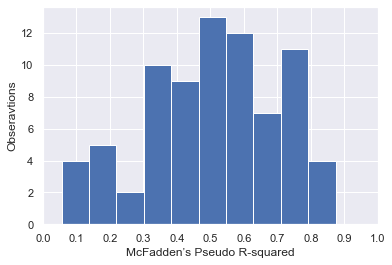

In [185]:
rr_df = pd.DataFrame(data=r_df)
rr_df
sr_df = rr_df.drop(N)
sr_df
max_sr = sr_df.max(axis=1)
max_sr

ax1 = plt.hist(max_sr,bins = 10)
plt.xticks(np.arange(0, 1.1, step=0.1))

plt.xlabel('McFadden’s Pseudo R-squared')
plt.ylabel('Obseravtions')
#plt.savefig('../../Figures/Presentation_Figure/VAF.png',dpi=1000)

Text(0, 0.5, 'Obseravtions')

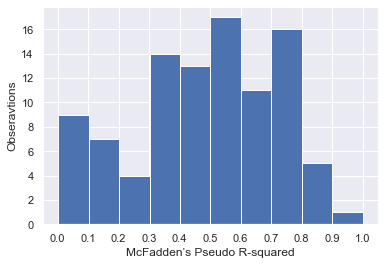

In [251]:
#create another column with the sp[idx_r]
max_r = rr_df.max(axis=1)
idx_r = rr_df.idxmax(axis = 1)

ax2 = plt.hist(max_r,bins =10)
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.xlabel('McFadden’s Pseudo R-squared')
plt.ylabel('Obseravtions')
#plt.savefig('../../Figures/Presentation_Figure/VAF_all.png',dpi=1000)


In [55]:
sratio_rt_df = ratio_rt_df.drop(N)


-0.2996591587500778
-0.1040611411701901


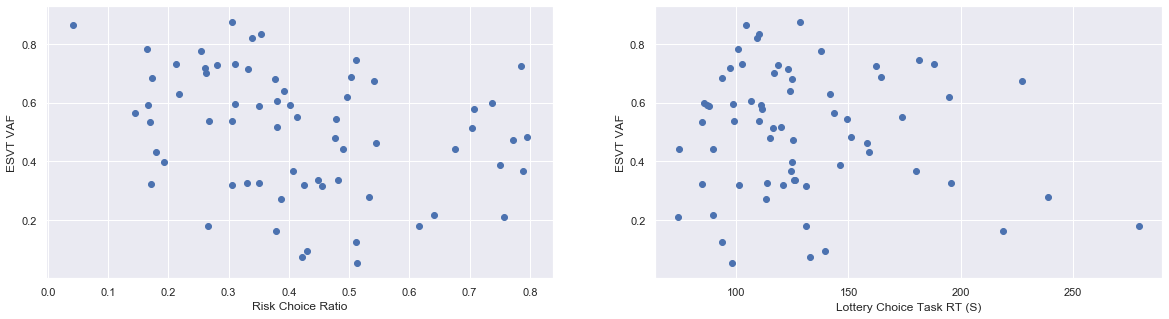

In [562]:
fig, ax = plt.subplots(figsize=(20, 5))
ax1 = plt.subplot(121)
plt.scatter(sratio_rt_df['risk_ratio'],max_sr)
plt.xlabel('Risk Choice Ratio')
plt.ylabel('ESVT VAF')
print(sratio_rt_df['risk_ratio'].corr(max_sr))

ax2 = plt.subplot(122)
plt.scatter(sratio_rt_df['RT'],max_sr)
plt.xlabel('Lottery Choice Task RT (S)')
plt.ylabel('ESVT VAF')

print(sratio_rt_df['RT'].corr(max_sr))

0.20854112947713427
0.08734109020019272


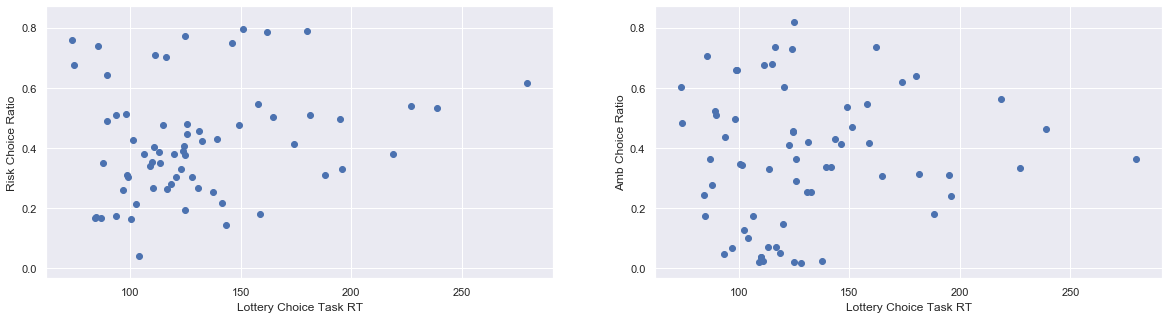

In [623]:
fig, ax = plt.subplots(figsize=(20, 5))
ax1 = plt.subplot(121)
plt.scatter(sratio_rt_df['RT'],sratio_rt_df['risk_ratio'])
plt.xlabel('Lottery Choice Task RT')
plt.ylabel('Risk Choice Ratio')
print(sratio_rt_df['RT'].corr(sratio_rt_df['risk_ratio']))

ax2 = plt.subplot(122,sharex=ax1, sharey=ax1)
plt.scatter(sratio_rt_df['RT'],sratio_rt_df['amb_ratio'])
plt.xlabel('Lottery Choice Task RT')
plt.ylabel('Amb Choice Ratio')
print(sratio_rt_df['RT'].corr(sratio_rt_df['amb_ratio']))

## EU fitting 

In [73]:
def raw_data_df(sub,cohort):
    subID = subID_list()
    if cohort != 177:
        week_label = ['01','08','11','17','19','23','26','32','34','36','42','44','48','52','56']
    else:
        week_label = ['01','04','08','11','17','19','23','26','32','34','37','42','44','48','52','56']
    filelist = []
    file = []
    
    for i in range(len(week_label)):
        lottery_file = '/Users/zyy219/Documents/Risk_project/Data/RP/study_%s_Levy Probability Choice Task - Healthy North American_%s.zip'%(cohort,week_label[i])
        filelist += zp.ZipFile(lottery_file).namelist()
        file.append(zp.ZipFile(lottery_file))
        
    sub_file = {}
    for i in range(len(subID)):
        key = subID[i]
        sub_file.setdefault(key, [])
        sub_file[key].extend([s for s in filelist if subID[i] in s])


    appended_data = []
    for i in range(len(file)):
        
        data = pd.read_csv(file[i].open(sub_file[sub][i]))
        
        appended_data.append(data)
    df = pd.concat(appended_data)
    r = df[df['data_rounds_trial_type'] == 'risk']
    return r

#525 #560
def analysis_data(df,obs):
    df.data_rounds_selected_sure_bet_reward = df.data_rounds_selected_sure_bet_reward.astype(int)
    df_temp = df[['participant_id','data_rounds_reward_probability','data_rounds_reward_value','data_rounds_selected_sure_bet_reward','data_rounds_trial_type','data_rounds_ambiguity']]
    df_temp.loc[df.data_rounds_trial_type  == 'ambiguity', 'data_rounds_reward_probability'] = 0.5
    df_temp.loc[:,'data_rounds_selected_sure_bet_reward'] = df_temp['data_rounds_selected_sure_bet_reward'].replace({0:1, 1:0})
    df_temp = df_temp.rename(columns={"data_rounds_selected_sure_bet_reward": "data_rounds_selected_variable_bet_reward"})
    x = np.array(df_temp['data_rounds_reward_value'])
    x = np.reshape(x,[obs,1])
    p = np.array(df_temp['data_rounds_reward_probability'])
    p = np.reshape(p,[obs,1])
    s = 5*np.ones((obs,1))
    A = np.array(df['data_rounds_ambiguity'])
    A = np.reshape(A,[obs,1])
    SubjectChoices = np.array(df_temp['data_rounds_selected_variable_bet_reward'])
    SubjectChoices = np.reshape(SubjectChoices,[obs,1])
    exog = np.concatenate((x,p,s,A), axis=1)
    endog = SubjectChoices

    return df_temp, exog, endog  

def _ll_nb2_EU(endog, exog, alpha, beta, gamma):

    x = exog[:,0]
    p = exog[:,1]
    s = exog[:,2]
    A = exog[:,3]
    SV_X = (p-beta*(A/2)) * np.power(x,alpha)
    SV_Y = np.power(s,alpha)
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y)))
    temp = 1-prob
    prob[endog == 0] = temp[endog == 0]
    negLL = -np.sum(np.log(prob))
    #negLL = -np.log(prob)
    return negLL

class EU(GenericLikelihoodModel):
#class Bin(LikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(EU, self).__init__(endog, exog, **kwds)

    def nloglikeobs(self,parms):
        alpha = parms[0]
        beta = parms[1]
        gamma = parms[2]
        negll = _ll_nb2_EU(self.endog, self.exog, alpha, beta, gamma)          
        return negll
    

    def fit(self, start_params, method='L-BFGS-B',bounds = ((0, None), (-1, 1), (0, None)) ,maxiter=10000, maxfun=50000, **kwds):
        # we have one additional parameter and we need to add it for summary
        #self.exog_names.append('gamma')
        #if start_params == None:
            # Reasonable starting values
            #start_params = np.array([0.9,0,1])
            # intercept
            #start_params[-2] = np.log(self.endog.mean())
        return super(EU, self).fit(start_params=start_params,method='lbfgs',bounds = ((0, None), (-1, 1), (0, None)),
                                     maxiter=maxiter, maxfun=maxfun,
                                     **kwds)

def r_squared_EU(alpha,beta,gamma,exog,endog,obs):
    x = exog[:,0]
    p = exog[:,1]
    s = exog[:,2]
    A = exog[:,3]

    SV_X = (p-beta*(A/2)) * np.power(x,alpha)
    SV_Y = np.power(s,alpha)
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y))).reshape((obs,1))
    temp = 1-prob
    prob[endog == 0] = temp[endog == 0]
    full_m_ll  = np.sum(np.log(prob))
    null_m_ll = -obs*np.log(2)
    r = 1- full_m_ll/null_m_ll
    return r

def AIC_BIC(endog, exog, alpha, beta, gamma,k,obs):
    x = exog[:,0]
    p = exog[:,1]
    s = exog[:,2]
    A = exog[:,3]

    SV_X = (p-beta*(A/2)) * np.power(x,alpha)
    SV_Y = np.power(s,alpha)
    prob = 1/(1+np.exp(-gamma*(SV_X-SV_Y))).reshape((obs,1))
    temp = 1-prob
    prob[endog == 0] = temp[endog == 0]
    nll  = -np.sum(np.log(prob))
    
    aic = 2*nll +2*k
    bic = 2*nll +k*np.log(obs)
    return aic,bic



In [74]:
A_sp = np.array([0.9,0.5,0.1])
B_sp = np.array([0,-0.5,0.5])
G_sp = np.array([0.3,1,2])
sp_eu = []
for i in A_sp:
    for y in B_sp:
        for r in G_sp:
            sp_eu.append(np.array([i,y,r]))
           

In [75]:
f_dict_EU = {}
k = 2
for t in range(27):
    params_array = np.empty([len(subID),6])
    for i in range(len(subID)):
        if GetCohort(subID[i]) != 177:
            obs = 255
        else:
            obs = 272
        dd = raw_data_df(subID[i],GetCohort(subID[i]))
        df_temp, exog, endog = analysis_data(dd,obs)
        mod = EU(endog, exog)
        res = mod.fit(sp_eu[t])
        params_array[i,0:3] = res.params
        alpha = res.params[0]
        beta = res.params[1]
        gamma = res.params[2]
        r = r_squared_EU(alpha,beta,gamma,exog,endog,obs)
        aic,bic = AIC_BIC(endog, exog, alpha, beta, gamma,k,obs)
        
        params_array[i,3] = r
        params_array[i,4] = aic
        params_array[i,5] = bic
    fitting_df = pd.DataFrame(data=np.round(params_array,3), index=subID_list(), columns=["alpha", "Beta","Gamma","R_squared","aic","bic"])
    f_dict_EU[t] = fitting_df
        

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:49

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:49

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:49

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:49

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:49

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:49

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:49

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:919: ValueWarning: more exog_names than parameters
  warnings.warn('more exog_names than parameters', ValueWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/lib/python3.7/site-packages/statsmodels/base/

In [99]:

r_df_EU = np.empty([len(subID),27])
aic_df_EU = np.empty([len(subID),27])
bic_df_EU = np.empty([len(subID),27])
for i in range(27):
    r_df_EU[:,i]= f_dict_EU[i]['R_squared']
    aic_df_EU[:,i] = f_dict_EU[i]['aic']
    bic_df_EU[:,i]=  f_dict_EU[i]['bic']

In [141]:


ro = np.zeros([len(subID),2])
ao = 1000*np.ones([len(subID),3])
for i in range(len(subID)):
    for t in range(27):
        r = f_dict_EU[t]['R_squared'][i]
        a = f_dict_EU[t]['aic'][i]
        b = f_dict_EU[t]['bic'][i]
        if r > ro[i,0]:
            ro[i,0] = r
            ro[i,1] = t
            #print(t)
        if a < ao[i,0]:
            ao[i,0] = a
            ao[i,1] = b
            ao[i,2] = t
            


In [269]:
best_fit = []
for i in range(len(subID)):
    a = f_dict_EU[ro[:,1][i]]['alpha'][i]
    g = f_dict_EU[ro[:,1][i]]['Gamma'][i]
    r = f_dict_EU[ro[:,1][i]]['R_squared'][i]
    aic = f_dict_EU[ro[:,1][i]]['aic'][i]
    bic = f_dict_EU[ro[:,1][i]]['bic'][i]
    
    
    #ESVT
    ae = f_dict[ro_ESVT[:,1][i]]['alpha'][i]
    m = f_dict[ro_ESVT[:,1][i]]['M'][i]
    ge = f_dict[ro_ESVT[:,1][i]]['Gamma'][i]
    re = f_dict[ro_ESVT[:,1][i]]['R_squared'][i]
    aice = f_dict[ro_ESVT[:,1][i]]['aic'][i]
    bice = f_dict[ro_ESVT[:,1][i]]['bic'][i]
    
    
    best_fit.append([a,g,r,aic,bic,ae,m,ge,re,aice,bice])

dep_variable = pd.DataFrame(data=best_fit,columns = 
             ['alpha_EU','gamma_EU','r_EU','aic_EU','bic_EU','alpha_ESVT','M_ESVT','gamma_ESVT',
             'r_ESVT','aic_ESVT','bic_ESVT'])

dep_variable.to_csv("/Users/zyy219/Documents/Risk_project/Data/Dependent_variable.csv")
dep_variable

,alpha_EU,gamma_EU,r_EU,aic_EU,bic_EU,alpha_ESVT,M_ESVT,gamma_ESVT,r_ESVT,aic_ESVT,bic_ESVT
0,0.624,3.520,0.641,131.058,138.141,1.000,25.087,59.220,0.605,145.706,156.330
1,0.609,1.892,0.381,222.963,230.045,1.000,22.349,28.261,0.368,229.528,240.151
2,0.698,1.552,0.404,214.561,221.644,1.000,38.166,33.913,0.321,246.078,256.702
3,0.727,1.532,0.436,203.308,210.390,1.000,38.399,47.973,0.444,202.480,213.104
4,0.600,0.793,0.107,319.646,326.729,1.000,20.661,9.222,0.075,332.899,343.523
5,0.560,2.149,0.393,218.676,225.759,1.000,16.955,20.506,0.326,244.401,255.025
6,0.290,2.095,0.313,247.033,254.116,3.977,4.685,7.391,0.330,242.826,253.450
7,0.000,1.185,0.093,324.594,331.677,1.000,0.000,1.185,0.093,326.594,337.218
8,1.462,0.020,0.110,318.554,325.636,123.350,9.027,3.385,0.194,291.092,301.716
9,0.000,0.000,-0.000,357.505,364.588,24.123,65.127,2.804,0.002,358.909,369.533


In [270]:
print(N)
sub_dep = dep_variable.drop(N)
sub_dep

[6, 7, 8, 9, 17, 21, 23, 28, 29, 33, 39, 49, 53, 55, 58, 62, 67, 82, 85, 92]


,alpha_EU,gamma_EU,r_EU,aic_EU,bic_EU,alpha_ESVT,M_ESVT,gamma_ESVT,r_ESVT,aic_ESVT,bic_ESVT
0,0.624,3.520,0.641,131.058,138.141,1.000,25.087,59.220,0.605,145.706,156.330
1,0.609,1.892,0.381,222.963,230.045,1.000,22.349,28.261,0.368,229.528,240.151
2,0.698,1.552,0.404,214.561,221.644,1.000,38.166,33.913,0.321,246.078,256.702
3,0.727,1.532,0.436,203.308,210.390,1.000,38.399,47.973,0.444,202.480,213.104
4,0.600,0.793,0.107,319.646,326.729,1.000,20.661,9.222,0.075,332.899,343.523
5,0.560,2.149,0.393,218.676,225.759,1.000,16.955,20.506,0.326,244.401,255.025
10,0.521,3.337,0.559,159.761,166.844,2.021,6.311,31.040,0.730,101.372,111.995
11,0.604,2.503,0.492,183.744,190.827,1.147,15.880,40.251,0.552,164.286,174.910
12,1.155,0.230,0.374,225.173,232.255,1.521,25.086,24.047,0.388,222.505,233.129
13,0.464,4.114,0.634,133.430,140.513,1.000,10.505,27.673,0.628,137.577,148.200


[-5.00710e+01 -4.74930e+01 -3.58290e+01 -3.15170e+01 -3.02340e+01
 -2.57250e+01 -2.55670e+01 -2.35280e+01 -2.26760e+01 -1.66450e+01
 -1.46480e+01 -1.43950e+01 -1.32530e+01 -1.05920e+01 -1.00120e+01
 -9.98200e+00 -9.89100e+00 -6.56500e+00 -4.14700e+00 -2.85700e+00
 -2.84400e+00 -2.00300e+00 -9.73000e-01 -2.88000e-01 -6.40000e-02
  2.64000e-01  4.55000e-01  5.57000e-01  8.28000e-01  9.35000e-01
  1.02900e+00  2.62400e+00  2.66800e+00  3.02000e+00  3.04300e+00
  3.26400e+00  4.70200e+00  4.80800e+00  4.85800e+00  4.98400e+00
  6.97400e+00  8.72300e+00  9.27300e+00  9.84600e+00  9.94600e+00
  9.95100e+00  1.00480e+01  1.28690e+01  1.38630e+01  1.53810e+01
  1.61510e+01  1.78850e+01  1.91990e+01  1.94580e+01  2.00020e+01
  2.64930e+01  2.77520e+01  2.86540e+01  2.93790e+01  3.12750e+01
  3.36120e+01  4.09910e+01  4.12530e+01  4.36790e+01  4.79870e+01
  4.86860e+01  5.27420e+01  5.31250e+01  5.83890e+01  7.07620e+01
  7.17170e+01  8.59950e+01  9.50180e+01  9.96290e+01  1.01502e+02
  1.24907e

Text(0.5, 0, 'aic_EU-aic_ESVT')

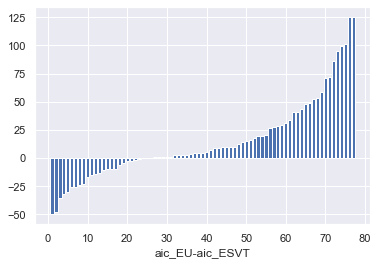

In [288]:
aic_d = sub_dep['aic_EU']-sub_dep['aic_ESVT']
print(np.sort(aic_d))
plt.bar(np.arange(1,78),np.sort(aic_d))
plt.xlabel('aic_EU-aic_ESVT')

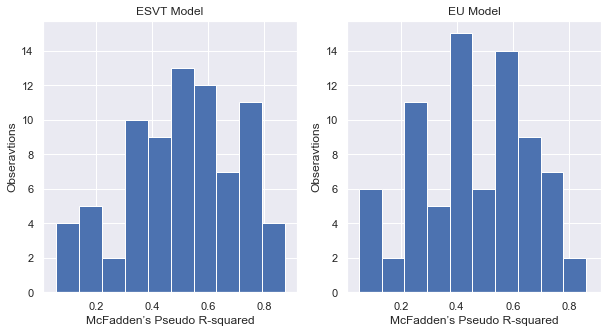

In [273]:
fig, ax = plt.subplots(figsize=(10, 5))
ax1 = plt.subplot(121)
plt.hist(sub_dep['r_ESVT'],bins = 10)
plt.title('ESVT Model')
plt.xlabel('McFadden’s Pseudo R-squared')
plt.ylabel('Obseravtions')

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.hist(sub_dep['r_EU'],bins = 10)
#plt.xticks(np.arange(0, 1.1, step=0.1))
plt.title('EU Model')
plt.xlabel('McFadden’s Pseudo R-squared')
plt.ylabel('Obseravtions')
plt.savefig('../../Figures/Presentation_Figure/VAF_EU_ESVT_updated.png',dpi=1000)



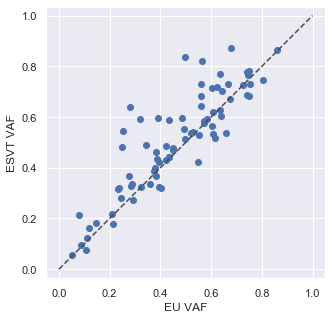

In [274]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(sub_dep['r_EU'],sub_dep['r_ESVT'])
#print(ax.get_xlim())
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.axis('equal')
plt.xlabel('EU VAF')
plt.ylabel('ESVT VAF')
plt.savefig('../../Figures/Presentation_Figure/scatter_EU_ESVT_updated.png',dpi=1000)


In [276]:
iv_df = pd.read_csv("/Users/zyy219/Documents/Risk_project/Data/Independent_variable.csv")
iv_df

,Unnamed: 0,E_EB,F_EB,S_EB,R_EB,S_EB.1,E_LI,F_LI,S_LI,R_LI,...,drm_neg,BAS,BIS,BIS11,UPPS,phq,stais,stait,bai,bsi
0,797,16.0,20.0,12.0,13.0,22.0,14.0,15.0,14.0,10.0,...,1.823125,33.0,19.0,68.0,114.0,6.00,51.00,52.0,11.0,45.0
1,806,14.0,19.0,16.0,14.0,19.0,10.0,13.0,15.0,15.0,...,1.135000,31.0,17.0,62.0,87.0,6.00,50.00,43.0,14.0,25.0
2,809,23.0,20.0,10.0,18.0,29.0,23.0,16.0,23.0,17.0,...,1.406250,20.0,16.0,79.0,104.0,7.00,54.00,48.0,14.0,63.0
3,826,19.0,23.0,12.0,15.0,27.0,18.0,20.0,22.0,26.0,...,2.093125,30.0,15.0,63.0,134.0,5.00,43.00,46.0,6.0,28.0
4,843,15.0,20.0,10.0,18.0,29.0,17.0,23.0,16.0,24.0,...,0.291875,26.0,14.0,60.0,122.0,5.00,36.00,26.0,0.0,7.0
5,845,19.0,17.0,11.0,15.0,24.0,18.0,17.0,23.0,12.0,...,0.426875,23.0,15.0,69.0,109.0,2.00,35.00,39.0,5.0,19.0
6,855,16.0,17.0,8.0,24.0,33.0,21.0,13.0,32.0,19.0,...,0.729375,24.0,10.0,74.0,148.0,12.00,51.00,59.0,20.0,29.0
7,856,16.0,13.0,10.0,13.0,22.0,20.0,17.0,11.0,12.0,...,0.000000,22.0,13.0,60.0,101.0,1.00,33.00,29.0,2.0,9.0
8,857,22.0,26.0,19.0,24.0,29.0,19.0,26.0,25.0,21.0,...,2.188125,29.0,15.0,77.0,142.0,2.00,46.00,41.0,10.0,66.0
9,1031,20.0,27.0,22.0,24.0,20.0,34.0,40.0,23.0,38.0,...,1.780000,23.0,11.0,74.0,158.0,8.00,53.00,49.0,17.0,96.0


In [179]:
corr_risk = []
corr_risk_p = []


corr_rt = []
corr_rt_p = []

corr_amb = []
corr_amb_p = []

In [183]:


data_rt = mean_RT.reshape(97,).tolist()
data_risk_ratio = mean_risk_ratio.reshape(97,).tolist()
#data_amb_ratio = mean_amb_ratio.reshape(97,).tolist()
var_NO = np.shape(iv_df)[1]

for i in range(var_NO-1): 
    
    data2 = iv_df.iloc[:,i+1].tolist()
    corr, _ = pearsonr(data_rt, data2)
    corr1,_1 = pearsonr(data_risk_ratio,data2)  
    corr2,_2 = pearsonr(data_amb_ratio,data2)
    corr_rt.append(corr)
    corr_rt_p.append(_)
    corr_risk.append(corr1)
    corr_risk_p.append(_1)
    #corr_amb.append(corr2)
    #corr_amb_p.append(_2)
        

In [170]:
label = ['E_EB','F_EB','S_EB','R_EB','S_EB','E_LI','F_LI','S_LI','R_LI','S_LI','E_RP','F_RP','S_RP','R_RP','S_RP',
        'IUS','lot_pos','lot_neg','drm_pos','drm_neg','BAS','BIS','BIS11','UPPS',
         'phq','stais','stait','bai','bsi']
matx = pd.DataFrame([corr_risk,corr_amb,corr_rt],index = ['Risk_ratio','Amb_ratio','RTs'],columns=label)
matx

NameError: name 'corr_amb' is not defined

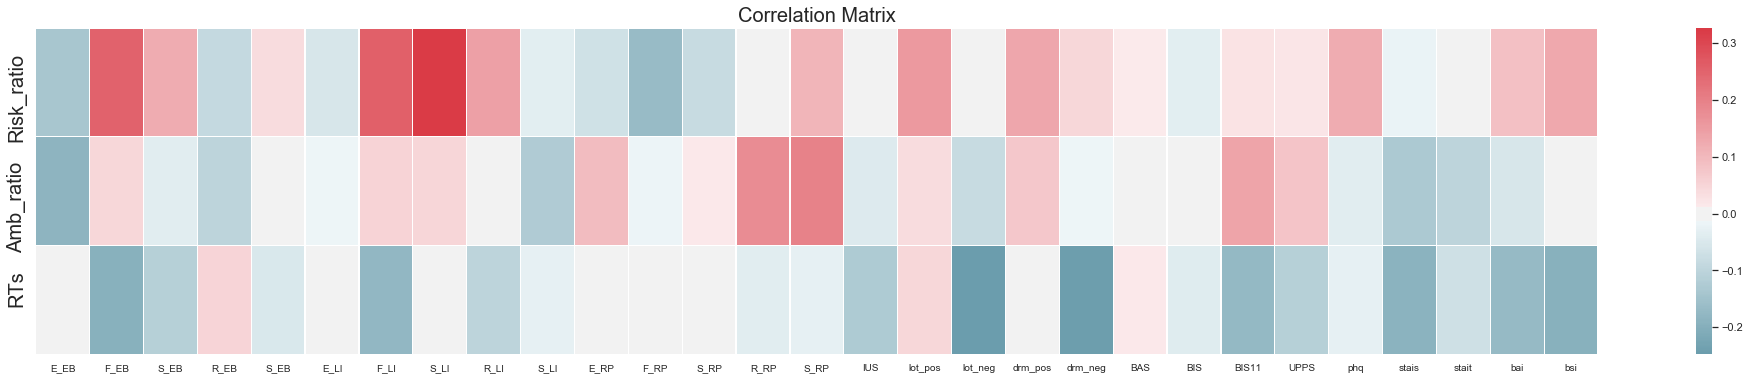

In [798]:
f, ax = plt.subplots(figsize=(35, 6))
        
        # Diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

        # Draw the heatmap with a color bar
sns.heatmap(matx, cmap=cmap, center=0,
                    linewidths=0.25, cbar_kws={"shrink": 1})

        # Set the ylabels 
ax.set_yticks([x + 0.3 for x in list(range(matx.shape[0]))])
ax.set_yticklabels(list(matx.index),size = 20);

        # Set the xlabels 
ax.set_xticks([x + 0.5 for x in list(range(matx.shape[1]))])
ax.set_xticklabels(list(matx.columns), size = 10);
plt.title('Correlation Matrix', size = 20)
plt.savefig('../../Figures/Presentation_Figure/correlation_matx1.png',dpi=500)